In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 100
LR = 1e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

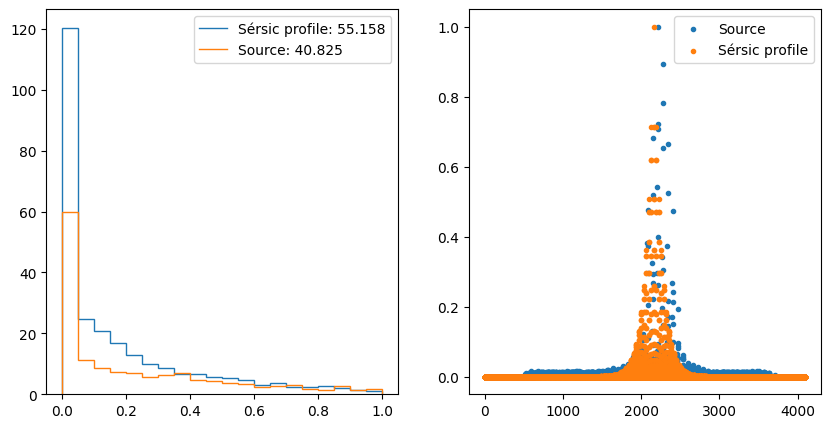

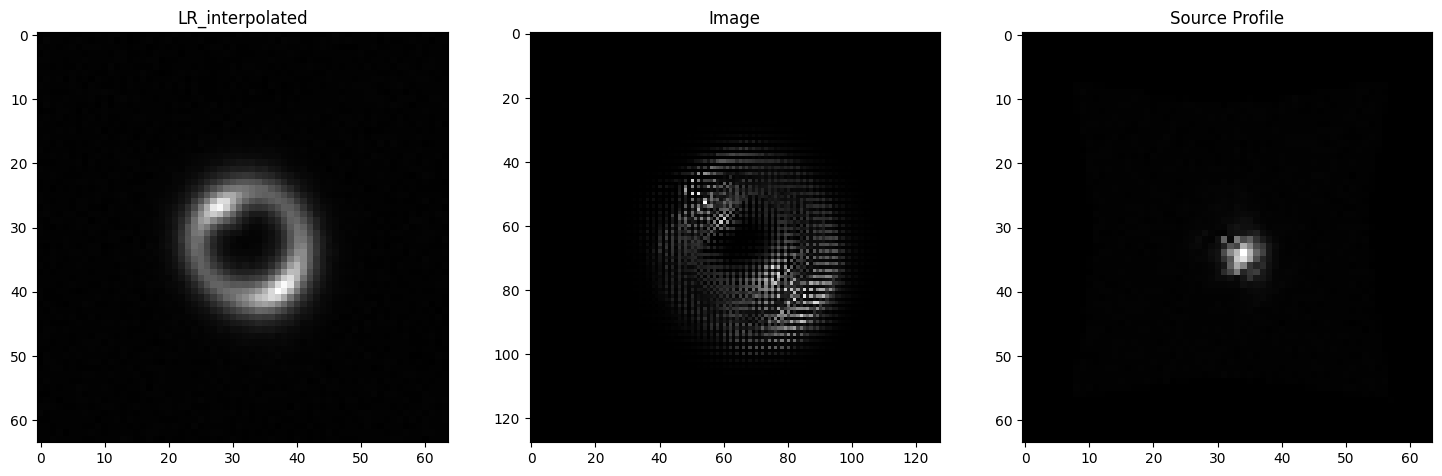

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1:   0%|          | 0/816 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 816/816 [00:43<00:00, 18.90it/s]


Training at epoch 1/100: 0.012208242818494058 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 33.43it/s]


Validation at epoch 1/100: 0.012004443279960572 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [00:43<00:00, 18.62it/s]


Training at epoch 2/100: 0.012164759741840413 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 31.21it/s]


Validation at epoch 2/100: 0.012174554059610647 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [00:44<00:00, 18.54it/s]


Training at epoch 3/100: 0.012253340484355307 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 31.37it/s]


Validation at epoch 3/100: 0.01214807907886365 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [00:44<00:00, 18.32it/s]


Training at epoch 4/100: 0.012144441529195388 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 31.06it/s]


Validation at epoch 4/100: 0.011763097462700864 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [00:44<00:00, 18.18it/s]


Training at epoch 5/100: 0.0120610193356269 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 30.42it/s]


Validation at epoch 5/100: 0.011820402608125233 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [00:44<00:00, 18.14it/s]


Training at epoch 6/100: 0.011224776399139241 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 31.01it/s]


Validation at epoch 6/100: 0.011197309269953298 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [00:45<00:00, 18.01it/s]


Training at epoch 7/100: 0.010600078933730758 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 30.32it/s]


Validation at epoch 7/100: 0.010488601765531461 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [00:45<00:00, 18.03it/s]


Training at epoch 8/100: 0.010290705463072905 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 30.62it/s]


Validation at epoch 8/100: 0.010316372348004768 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [00:45<00:00, 18.09it/s]


Training at epoch 9/100: 0.01006410921542613 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 31.62it/s]


Validation at epoch 9/100: 0.01026828029345922 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [00:45<00:00, 17.79it/s]


Training at epoch 10/100: 0.009974727940668043 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 29.42it/s]


Validation at epoch 10/100: 0.010116696367428329 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [00:46<00:00, 17.71it/s]


Training at epoch 11/100: 0.009953638037675811 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 29.43it/s]


Validation at epoch 11/100: 0.010025058261246658 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [00:46<00:00, 17.70it/s]


Training at epoch 12/100: 0.009976394875682706 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 30.40it/s]


Validation at epoch 12/100: 0.009977279712592125 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [00:46<00:00, 17.45it/s]


Training at epoch 13/100: 0.009983623269077976 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 31.08it/s]


Validation at epoch 13/100: 0.009890836901510791 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [00:46<00:00, 17.70it/s]


Training at epoch 14/100: 0.00968634067177453 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:07<00:00, 28.98it/s]


Validation at epoch 14/100: 0.009156643729725415 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [00:45<00:00, 17.94it/s]


Training at epoch 15/100: 0.00930019897550308 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 30.57it/s]


Validation at epoch 15/100: 0.009308852111537229 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [00:44<00:00, 18.54it/s]


Training at epoch 16/100: 0.009225524479452539 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 32.90it/s]


Validation at epoch 16/100: 0.008984237117806961 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [00:41<00:00, 19.67it/s]


Training at epoch 17/100: 0.009203717979378816 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:05<00:00, 35.40it/s]


Validation at epoch 17/100: 0.00907987709626254 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [00:40<00:00, 20.16it/s]


Training at epoch 18/100: 0.009109585111396954 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:05<00:00, 35.24it/s]


Validation at epoch 18/100: 0.008890697324543497 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [00:40<00:00, 20.17it/s]


Training at epoch 19/100: 0.009059704905809542 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:05<00:00, 35.65it/s]


Validation at epoch 19/100: 0.008697889917861103 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [00:40<00:00, 20.09it/s]


Training at epoch 20/100: 0.00901145579558158 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:05<00:00, 35.69it/s]


Validation at epoch 20/100: 0.008817189397043823 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [00:40<00:00, 20.01it/s]


Training at epoch 21/100: 0.00898769274371101 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:05<00:00, 35.09it/s]


Validation at epoch 21/100: 0.00883432631092671 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [00:40<00:00, 20.04it/s]


Training at epoch 22/100: 0.008962028626211024 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:05<00:00, 35.91it/s]


Validation at epoch 22/100: 0.00870785002759886 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [00:41<00:00, 19.78it/s]


Training at epoch 23/100: 0.008948178204032136 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:05<00:00, 34.87it/s]


Validation at epoch 23/100: 0.008703589262771785 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [00:40<00:00, 19.93it/s]


Training at epoch 24/100: 0.008914351287268231 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:05<00:00, 35.74it/s]


Validation at epoch 24/100: 0.008740939077802514 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [00:40<00:00, 19.99it/s]


Training at epoch 25/100: 0.008884099010388394 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:05<00:00, 34.33it/s]


Validation at epoch 25/100: 0.00866478803286822 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [00:40<00:00, 19.91it/s]


Training at epoch 26/100: 0.008867378188548243 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:05<00:00, 35.18it/s]


Validation at epoch 26/100: 0.008570469268877287 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [00:40<00:00, 20.05it/s]


Training at epoch 27/100: 0.008813777519903584 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:05<00:00, 35.42it/s]


Validation at epoch 27/100: 0.00866422746341913 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [00:40<00:00, 19.99it/s]


Training at epoch 28/100: 0.008774736420652036 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:05<00:00, 34.67it/s]


Validation at epoch 28/100: 0.008558419857781344 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [00:41<00:00, 19.71it/s]


Training at epoch 29/100: 0.008753152441903356 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:05<00:00, 34.22it/s]


Validation at epoch 29/100: 0.00854756381258816 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [00:41<00:00, 19.89it/s]


Training at epoch 30/100: 0.008740543204076662 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:05<00:00, 35.10it/s]


Validation at epoch 30/100: 0.008514682907130634 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [00:40<00:00, 20.14it/s]


Training at epoch 31/100: 0.008741978744521975 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:05<00:00, 35.87it/s]


Validation at epoch 31/100: 0.008547971596771294 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [00:40<00:00, 20.11it/s]


Training at epoch 32/100: 0.008725982146250887 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:05<00:00, 36.28it/s]


Validation at epoch 32/100: 0.008518219253293116 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [00:40<00:00, 20.08it/s]


Training at epoch 33/100: 0.008718940951118437 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:05<00:00, 35.63it/s]


Validation at epoch 33/100: 0.008470274184433305 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [00:40<00:00, 20.28it/s]


Training at epoch 34/100: 0.008693247222182954 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:05<00:00, 36.55it/s]


Validation at epoch 34/100: 0.008479562819725377 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [00:40<00:00, 20.21it/s]


Training at epoch 35/100: 0.008668459068062743 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:05<00:00, 35.49it/s]


Validation at epoch 35/100: 0.008476660350710269 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [00:40<00:00, 20.01it/s]


Training at epoch 36/100: 0.008605463825755149 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:05<00:00, 34.91it/s]


Validation at epoch 36/100: 0.00840322954415266 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [00:41<00:00, 19.56it/s]


Training at epoch 37/100: 0.008454427903879881 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:05<00:00, 35.60it/s]


Validation at epoch 37/100: 0.008190789953468815 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [00:40<00:00, 19.91it/s]


Training at epoch 38/100: 0.008282921379563334 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:05<00:00, 35.68it/s]


Validation at epoch 38/100: 0.0081284333136864 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [00:40<00:00, 20.19it/s]


Training at epoch 39/100: 0.008184379832813397 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:05<00:00, 35.60it/s]


Validation at epoch 39/100: 0.00799842933966098 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [00:40<00:00, 20.25it/s]


Training at epoch 40/100: 0.00806861679117063 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:05<00:00, 35.10it/s]


Validation at epoch 40/100: 0.007921129050373565 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [00:40<00:00, 20.34it/s]


Training at epoch 41/100: 0.0080518972245045 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:05<00:00, 35.73it/s]


Validation at epoch 41/100: 0.007908160199625784 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [00:40<00:00, 20.18it/s]


Training at epoch 42/100: 0.008016849904950005 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:05<00:00, 35.86it/s]


Validation at epoch 42/100: 0.007788371255004427 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [00:40<00:00, 20.34it/s]


Training at epoch 43/100: 0.007954607851513407 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:05<00:00, 35.63it/s]


Validation at epoch 43/100: 0.007770859145381894 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [00:40<00:00, 20.26it/s]


Training at epoch 44/100: 0.007908478771865953 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:05<00:00, 35.44it/s]


Validation at epoch 44/100: 0.007754137635749752 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [00:40<00:00, 20.37it/s]


Training at epoch 45/100: 0.007876088128849754 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:05<00:00, 35.63it/s]


Validation at epoch 45/100: 0.00768958381241628 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [00:40<00:00, 20.29it/s]


Training at epoch 46/100: 0.007862334803041235 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:05<00:00, 35.25it/s]


Validation at epoch 46/100: 0.0077258113199016355 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [00:40<00:00, 20.29it/s]


Training at epoch 47/100: 0.007817562987375092 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:05<00:00, 35.40it/s]


Validation at epoch 47/100: 0.007618846257351905 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [00:40<00:00, 20.35it/s]


Training at epoch 48/100: 0.007773820767647075 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:05<00:00, 35.80it/s]


Validation at epoch 48/100: 0.007637861666130359 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [00:40<00:00, 20.27it/s]


Training at epoch 49/100: 0.0077502532698346446 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:05<00:00, 35.82it/s]


Validation at epoch 49/100: 0.0075674923288056115 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [00:40<00:00, 20.31it/s]


Training at epoch 50/100: 0.007707973473075339 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:05<00:00, 36.41it/s]


Validation at epoch 50/100: 0.007450726171715789 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [00:40<00:00, 20.37it/s]


Training at epoch 51/100: 0.007653058947385836 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:05<00:00, 35.82it/s]


Validation at epoch 51/100: 0.007538001144840724 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [00:40<00:00, 20.21it/s]


Training at epoch 52/100: 0.0076587297751079765 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:05<00:00, 36.05it/s]


Validation at epoch 52/100: 0.007518290846586323 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [00:40<00:00, 20.25it/s]


Training at epoch 53/100: 0.007638616323175466 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:05<00:00, 36.27it/s]


Validation at epoch 53/100: 0.007457112487506546 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [00:40<00:00, 20.24it/s]


Training at epoch 54/100: 0.007607110058540688 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:05<00:00, 35.35it/s]


Validation at epoch 54/100: 0.007426524579618583 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [00:40<00:00, 20.22it/s]


Training at epoch 55/100: 0.007567856274060129 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:05<00:00, 35.76it/s]


Validation at epoch 55/100: 0.007387996121941993 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [00:40<00:00, 20.30it/s]


Training at epoch 56/100: 0.0075091589872802915 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:05<00:00, 35.96it/s]


Validation at epoch 56/100: 0.007317579896135059 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [00:39<00:00, 20.43it/s]


Training at epoch 57/100: 0.007469820070529 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:05<00:00, 35.86it/s]


Validation at epoch 57/100: 0.007314007871030424 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [00:40<00:00, 20.29it/s]


Training at epoch 58/100: 0.00743954165099079 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:05<00:00, 35.24it/s]


Validation at epoch 58/100: 0.007366835932628544 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [00:39<00:00, 20.43it/s]


Training at epoch 59/100: 0.007402908331035482 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:05<00:00, 35.72it/s]


Validation at epoch 59/100: 0.007187283137396912 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [00:40<00:00, 20.24it/s]


Training at epoch 60/100: 0.00731782976058015 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:05<00:00, 35.80it/s]


Validation at epoch 60/100: 0.0071318465819714735 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [00:40<00:00, 20.31it/s]


Training at epoch 61/100: 0.007210497912441782 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:05<00:00, 36.80it/s]


Validation at epoch 61/100: 0.007105141899884591 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [00:40<00:00, 20.17it/s]


Training at epoch 62/100: 0.007152619568075226 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:05<00:00, 36.09it/s]


Validation at epoch 62/100: 0.007083390366032665 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [00:40<00:00, 20.24it/s]


Training at epoch 63/100: 0.007120135640149123 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:05<00:00, 36.34it/s]


Validation at epoch 63/100: 0.007047851270280993 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [00:40<00:00, 20.36it/s]


Training at epoch 64/100: 0.007092689782510599 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:05<00:00, 35.16it/s]


Validation at epoch 64/100: 0.006992037658860414 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [00:40<00:00, 20.35it/s]


Training at epoch 65/100: 0.007061075810805265 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:05<00:00, 36.31it/s]


Validation at epoch 65/100: 0.007030152978354725 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [00:39<00:00, 20.40it/s]


Training at epoch 66/100: 0.007061875393749991 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:05<00:00, 35.56it/s]


Validation at epoch 66/100: 0.00701741943796115 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [00:40<00:00, 20.18it/s]


Training at epoch 67/100: 0.0070546901671845914 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:05<00:00, 34.32it/s]


Validation at epoch 67/100: 0.007036824618861667 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [00:40<00:00, 20.08it/s]


Training at epoch 68/100: 0.007046853221825087 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:05<00:00, 36.00it/s]


Validation at epoch 68/100: 0.00702572767555716 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [00:40<00:00, 20.08it/s]


Training at epoch 69/100: 0.007034253603242356 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:05<00:00, 35.55it/s]


Validation at epoch 69/100: 0.006994646179045246 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [00:40<00:00, 20.27it/s]


Training at epoch 70/100: 0.007012448281873767 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:05<00:00, 36.10it/s]


Validation at epoch 70/100: 0.0069749785965113375 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [00:40<00:00, 20.11it/s]


Training at epoch 71/100: 0.007007409122689197 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:05<00:00, 35.87it/s]


Validation at epoch 71/100: 0.00700589255882055 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [00:40<00:00, 20.16it/s]


Training at epoch 72/100: 0.0069990085814389015 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:05<00:00, 35.30it/s]


Validation at epoch 72/100: 0.007002747463654184 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [00:40<00:00, 20.17it/s]


Training at epoch 73/100: 0.007006218692064673 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:05<00:00, 35.47it/s]


Validation at epoch 73/100: 0.007011132253169575 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [00:40<00:00, 20.08it/s]


Training at epoch 74/100: 0.007003253942707042 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:05<00:00, 35.55it/s]


Validation at epoch 74/100: 0.007008116009291922 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [00:40<00:00, 20.12it/s]


Training at epoch 75/100: 0.0070066830192124195 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:05<00:00, 35.34it/s]


Validation at epoch 75/100: 0.006984221783033504 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [00:40<00:00, 20.11it/s]


Training at epoch 76/100: 0.007006456246231478 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:05<00:00, 35.69it/s]


Validation at epoch 76/100: 0.006980526136020689 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [00:40<00:00, 20.15it/s]


Training at epoch 77/100: 0.007010454077281597 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:05<00:00, 35.59it/s]


Validation at epoch 77/100: 0.006998087028906037 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [00:40<00:00, 20.20it/s]


Training at epoch 78/100: 0.007015355951914578 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:05<00:00, 35.44it/s]


Validation at epoch 78/100: 0.00696447631829263 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [00:40<00:00, 20.12it/s]


Training at epoch 79/100: 0.0069678903936280625 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:05<00:00, 35.85it/s]


Validation at epoch 79/100: 0.006984805373398486 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [00:40<00:00, 20.08it/s]


Training at epoch 80/100: 0.006965204488997365 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:05<00:00, 35.63it/s]


Validation at epoch 80/100: 0.006940217974154032 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [00:40<00:00, 20.20it/s]


Training at epoch 81/100: 0.006967677605251654 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:05<00:00, 36.38it/s]


Validation at epoch 81/100: 0.006953728094231337 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [00:40<00:00, 20.24it/s]


Training at epoch 82/100: 0.006971628649754326 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:05<00:00, 36.01it/s]


Validation at epoch 82/100: 0.006958832759860967 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [00:40<00:00, 20.09it/s]


Training at epoch 83/100: 0.006966687906313773 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:05<00:00, 36.63it/s]


Validation at epoch 83/100: 0.0069323469726405886 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [00:40<00:00, 20.38it/s]


Training at epoch 84/100: 0.006979381421058183 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:05<00:00, 36.45it/s]


Validation at epoch 84/100: 0.006945997603193688 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [00:40<00:00, 20.23it/s]


Training at epoch 85/100: 0.006987473624487357 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:05<00:00, 36.79it/s]


Validation at epoch 85/100: 0.006948389840866131 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [00:40<00:00, 20.22it/s]


Training at epoch 86/100: 0.006970533159819395 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:05<00:00, 36.17it/s]


Validation at epoch 86/100: 0.006927471943651885 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [00:40<00:00, 20.20it/s]


Training at epoch 87/100: 0.006964701324571197 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:05<00:00, 35.76it/s]


Validation at epoch 87/100: 0.00691657317585458 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [00:40<00:00, 20.28it/s]


Training at epoch 88/100: 0.0069675975266328145 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:05<00:00, 35.73it/s]


Validation at epoch 88/100: 0.006922034757379009 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [00:40<00:00, 20.27it/s]


Training at epoch 89/100: 0.006968292958238937 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:05<00:00, 36.35it/s]


Validation at epoch 89/100: 0.00693163754979597 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [00:40<00:00, 20.33it/s]


Training at epoch 90/100: 0.0069697917831089235 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:05<00:00, 36.08it/s]


Validation at epoch 90/100: 0.006919465058101695 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [00:40<00:00, 20.30it/s]


Training at epoch 91/100: 0.006968296622610925 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:05<00:00, 36.56it/s]


Validation at epoch 91/100: 0.006921993462110906 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [00:40<00:00, 20.33it/s]


Training at epoch 92/100: 0.006980609023622832 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:05<00:00, 36.06it/s]


Validation at epoch 92/100: 0.007049495366278708 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [00:40<00:00, 20.19it/s]


Training at epoch 93/100: 0.0069796477817398415 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:05<00:00, 35.84it/s]


Validation at epoch 93/100: 0.006957444972345805 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [00:40<00:00, 20.27it/s]


Training at epoch 94/100: 0.006976521586016044 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:05<00:00, 35.52it/s]


Validation at epoch 94/100: 0.0069353260951531565 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [00:40<00:00, 20.30it/s]


Training at epoch 95/100: 0.006984455606132043 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:05<00:00, 35.80it/s]


Validation at epoch 95/100: 0.006978590353908515 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [00:40<00:00, 20.39it/s]


Training at epoch 96/100: 0.006988515683213551 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:05<00:00, 35.65it/s]


Validation at epoch 96/100: 0.007003642543578263 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [00:39<00:00, 20.43it/s]


Training at epoch 97/100: 0.00698021767497195 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:05<00:00, 37.00it/s]


Validation at epoch 97/100: 0.006933127392745947 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [00:40<00:00, 20.29it/s]


Training at epoch 98/100: 0.0069756418340736715 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:05<00:00, 35.53it/s]


Validation at epoch 98/100: 0.006939523347076223 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [00:40<00:00, 20.35it/s]


Training at epoch 99/100: 0.006964389974004293 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:05<00:00, 35.96it/s]


Validation at epoch 99/100: 0.006912301502476718 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [00:40<00:00, 20.30it/s]


Training at epoch 100/100: 0.006971555259880524 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:05<00:00, 35.86it/s]

Validation at epoch 100/100: 0.006925464965224462 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

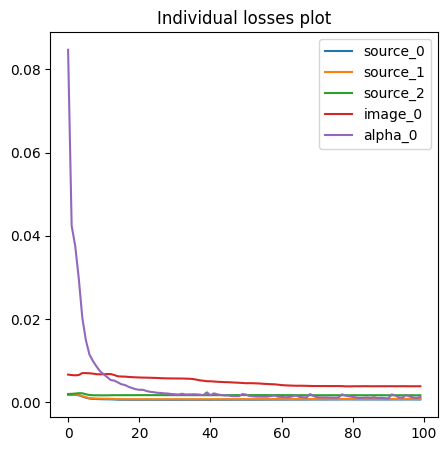

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

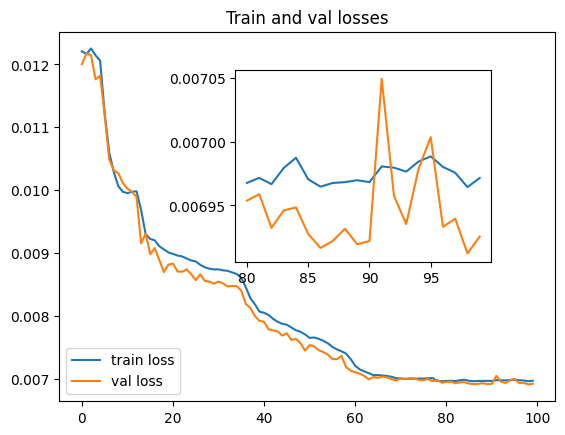

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.007606722428189481


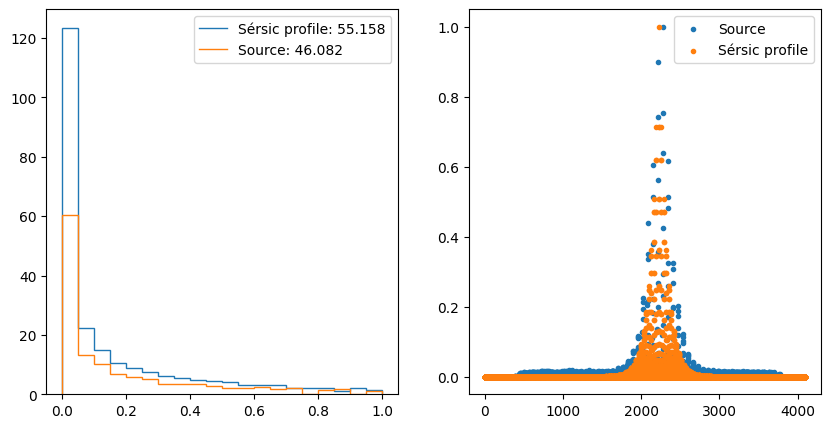

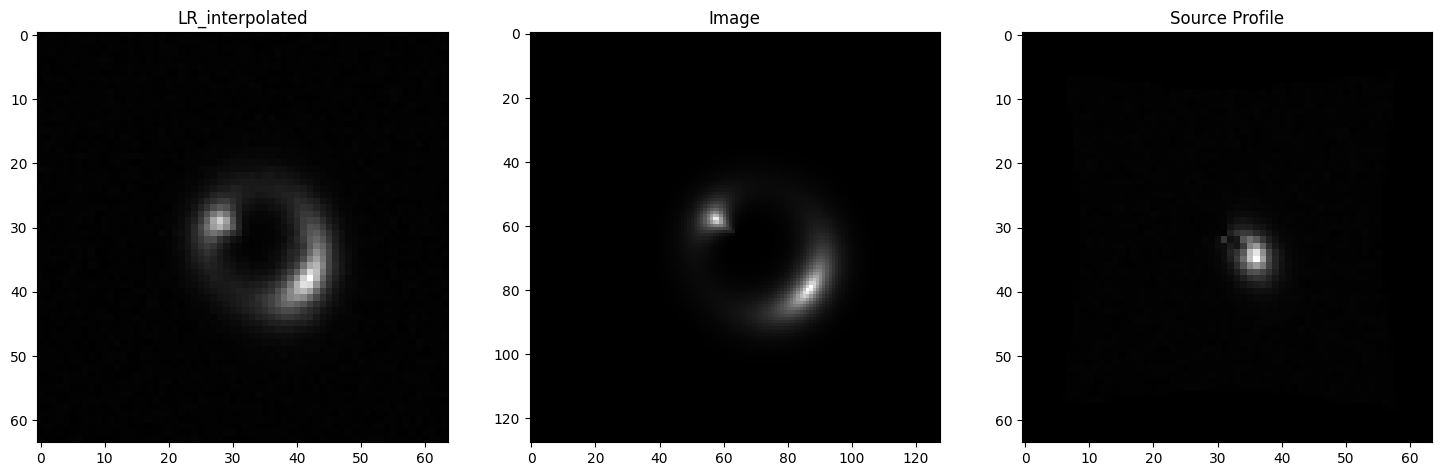

In [22]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [23]:
torch.save(best_weights, 'Weights_2.pt')